### Introduction
In the past decade or so, product reviews have become a major factor when customers are trying to decide on what to buy, whether that is food (Yelp), lodging (AirBnb, TripAdvisor, Expedia, etc.), or buying an item (Amazon, Target, etc.).  As such, sentiment review can be a helpful tool for both the consumer and the company.  For example, think about the last time you looked at reviews for a product on Amazon.  What were you looking for?  Perhaps it was quality and price point, or perhaps something to do with aesthetics like if the colors were true to the image.  For a company, they may be looking for how customers view their product overall, or if in the past few months there have been a lot of complaints, or even if certain parts of their product could be improved (i.e. good quality product but terrible customer service).  Overall, this comes down to sentiment analysis, or if we can identify if a review is positive or negative.  For this project, I wanted to know if we can apply sentiment analysis on Amazon reviews and get reliable results.  

A collection of Amazon customer reviews can be found on this [site](https://nijianmo.github.io/amazon/index.html).  Reviews are divided up into categories. I chose to investigate reviews for cell phones and accessories.  The data consists of 10 features, summarized below:

| Feature | Description   |
|------|------|
|   reviewerID and reviewerName  | Unique identifier for the reviewer and their name|
|   asin  | Unique identifier product|
|   style  | A description of the product|
|   reviewText and summary  | the summary and text of the review|
|   overall  | Average number of stars (out of 5)|
|   vote  | how many votes the review has (indicating if another user thought the review was helpful or not)|
|   unixReviewTime and reviewTime  | time of the review in unix and normal time|

In [1]:
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from tqdm import tqdm

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from wordcloud import WordCloud

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import make_pipeline

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models.word2vec import Word2Vec

from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


### 1 - Importing the Data
The raw data comes compressed, and for good reason.  Once unpacked, its almost 1 GB!  Based on the feature description above, there are two time related features that are redundant.  I'll remove the unix time since that is difficult to interpret. 

In [2]:
df = pd.read_json('reviews/Cell_Phones_and_Accessories_5.json.gz', lines = True)

In [3]:
df.drop('unixReviewTime', axis = 1, inplace = True)

In [4]:
df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128437 entries, 0 to 1128436
Data columns (total 11 columns):
asin            1128437 non-null object
image           27107 non-null object
overall         1128437 non-null int64
reviewText      1127672 non-null object
reviewTime      1128437 non-null object
reviewerID      1128437 non-null object
reviewerName    1128302 non-null object
style           605241 non-null object
summary         1127920 non-null object
verified        1128437 non-null bool
vote            92034 non-null object
dtypes: bool(1), int64(1), object(9)
memory usage: 958.9 MB


Lastly, I need to check if there are any missing values, especially in the review text and summary columns.  Unfortunately, there are but I will deal with it in future sections.

In [5]:
df.isnull().sum()

asin                  0
image           1101330
overall               0
reviewText          765
reviewTime            0
reviewerID            0
reviewerName        135
style            523196
summary             517
verified              0
vote            1036403
dtype: int64

###  2 - What is the Distribution of Ratings?
For sentiment analysis, I will be relying on the ratings.  Amazon ratings are on a 1-5 scale, with 1 and 5 being the lowest and highest ratings respectively.  The plot below shows the distribution of ratings.  Around 60% of the ratings are 5's, and about 15% are 4's, indicating that most reviewers view their products favorably.  

Unfortunately, there are lots of fake reviews which has resulted in websites such as fakespot.com and reviewmeta.com.  Identifying fake reivews is a task beyond the scope of this project.  For now, to reduce the likelihood of fake reviews contaminating results, I will remove 1 and 5 star reviews.


Text(0, 0.5, 'Count')

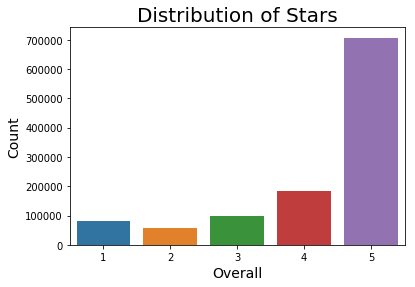

In [6]:
sns.countplot(x = 'overall', data = df)
plt.title('Distribution of Stars', fontsize = 20)
plt.xlabel('Overall', fontsize = 14)
plt.ylabel('Count', fontsize = 14)

In [7]:
df = df[(df['overall']!=1) & (df['overall'] != 5)]

There is also a feature that indicates if the reviewer has been verified that they have purchased the product.  I will remove any reviews that were not verified. 

In [8]:
df = df[df['verified']==True]
df.reset_index(drop = True, inplace = True)

Lastly, since the reviews are the heart of sentiment analysis, any reviews without text are removed from the dataset.  

In [9]:
df = df[df['reviewText'].notnull()]

At this point, there are only 2, 3 and 4 stars left.  These will indicate the sentiment of the analysis, with 2, 3, and 4 indicating negative, neutral, and positive sentiments.

In [10]:
def convert_ratings(col):
    if col == 2:
        return 'negative'
    elif col == 3:
        return 'neutral'
    elif col == 4:
        return 'positive'

In [11]:
df['overall'] = df['overall'].apply(convert_ratings)

The distribution of the sentiments are displayed below.  Positive sentiments are still the majority, at ~50 percent, and neutral and negative sentiments at ~30 and ~20% respectively.  

Text(0, 0.5, 'Count')

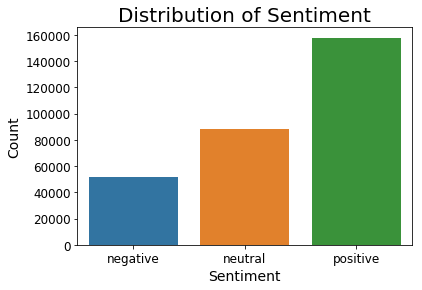

In [12]:
sentiment_order = ['negative', 'neutral', 'positive']

sns.countplot('overall', order = sentiment_order, data = df)
plt.title('Distribution of Sentiment', fontsize = 20)
plt.xlabel('Sentiment', fontsize = 14)
plt.tick_params(labelsize = 12)
plt.ylabel('Count', fontsize = 14)

### 3 - How Quickly did the Cell Phone Accessory Category Grow?
First, we need to know the time frame of this dataset.  The years range from 2002 to 2018.  In the plots below, the number of unique products by year (left) shows that the number of products slowly increases until 2011, where it rapidly increases until a peak in 2015 before declining.  The number of reviews by year (right) shows a similar trend, where the number of reviews slowly increases until 2011, rapidly increases until a peak in 2015 before declining.  

One would think that cell phones and its accessories would be a robust market, so I was confused by the decline in product and reviews.  But according to the [Pew Research Center's data](https://www.pewresearch.org/internet/fact-sheet/mobile/) on smartphone ownership, the number of people who owned a smartphone was increasing rapidly until 2016.  Coupled with smartphone [saturation and fatigue](https://www.androidauthority.com/smartphone-fatigue-881429/), there is simply less demand for phone accessories.  


In [13]:
df['year'] = df['reviewTime'].apply(lambda x: int(x[-4:]))

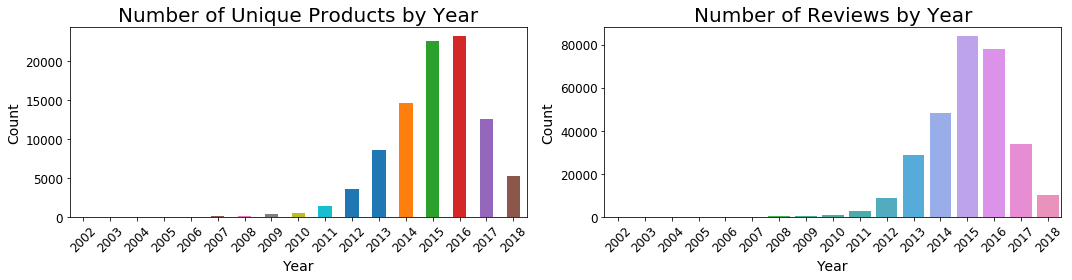

In [14]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

df.groupby(['year', 'asin']).count()['overall'].unstack().count(axis = 1).plot(kind = 'bar', ax = axis1)
sns.countplot('year', data = df, ax = axis2)


axis1.set_title('Number of Unique Products by Year', fontsize = 20)
axis2.set_title('Number of Reviews by Year', fontsize = 20)


for ax in [axis1, axis2]:
    ax.set_ylabel('Count', fontsize = 14)
    ax.set_xlabel('Year', fontsize = 14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()

Since the heart of this project is to predict sentiment from the reviews, I will exclude any reviews that are from 2011 and earlier, as the number of reviews didn't start trickling in till 2012.  

In [15]:
df = df[df['year'] > 2011]
df.reset_index(drop = True, inplace = True)

### 3 - Average Word Count
Sometimes, such as in the case of spam detection, word counts can differentiate between categories.  I would like to see if that is possible here.  Although I'm mainly looking at the review text, I've realized the summary could also be used to determine sentiment, so both reviews and summary are examined in this section.  

#### 3.1 - Review 
For whatever reason, there are quite a bit of reviews that have a single (nonsensical) letter in the review.  I will remove these from the dataset.  Single words are not a problem, as the most common single words are words such as 'good' or 'ok'.  

The word and character counts are slightly larger for negative reviews, with the mean word count for negative reviews at ~53 and ~49 for neutral and positive reviews.  Similar trends hold for character count.  In this case, word/character count may not be terribly useful.  

In [16]:
df['reviewText_words'] = df['reviewText'].apply(lambda x: len(x.split(' ')))
df['reviewText_char'] = df['reviewText'].apply(lambda x: len(x))

In [17]:
df = df[df['reviewText_char'] > 1]

/home/crystal/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


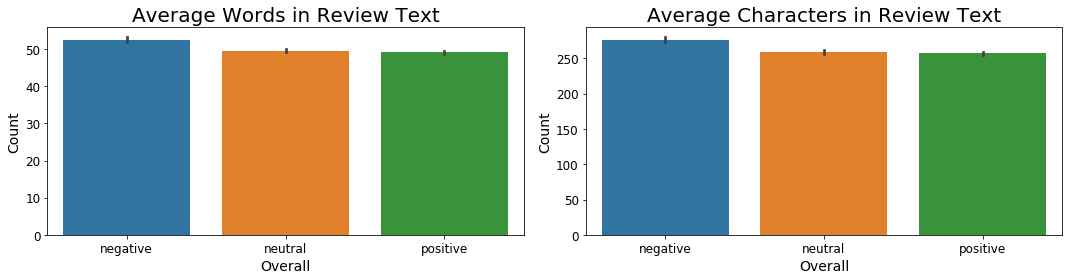

In [18]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x = 'overall', order = sentiment_order, y = 'reviewText_words', data = df, ax = axis1)
sns.barplot(x = 'overall', order = sentiment_order, y = 'reviewText_char', data = df, ax = axis2)

axis1.set_title('Average Words in Review Text', fontsize = 20)
axis2.set_title('Average Characters in Review Text', fontsize = 20)

for ax in [axis1, axis2]:
    ax.set_ylabel('Count', fontsize = 14)
    ax.set_xlabel('Overall', fontsize = 14)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

#### 3.2 - Summary
Summaries, as expected, have a smaller word and character count, with word counts at ~5 for all three sentiments.

In [19]:
df['summary'].fillna('', inplace = True)

In [20]:
df['summary_words'] = df['summary'].apply(lambda x: len(x.split(' ')))
df['summary_char'] = df['summary'].apply(lambda x: len(x))

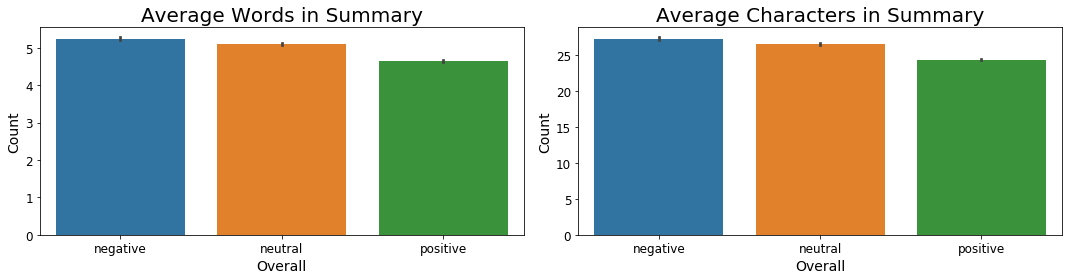

In [21]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x = 'overall', order = sentiment_order, y = 'summary_words', data = df, ax = axis1)
sns.barplot(x = 'overall', order = sentiment_order, y = 'summary_char', data = df, ax = axis2)

axis1.set_title('Average Words in Summary', fontsize = 20)
axis2.set_title('Average Characters in Summary', fontsize = 20)

for ax in [axis1, axis2]:
    ax.set_ylabel('Count', fontsize = 14)
    ax.set_xlabel('Overall', fontsize = 14)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

### 4 - Are there Key Words for each Sentiment?
Another technique helpful to sentiment analysis (or nlp in general) is to find key words unique to each category. To do this, first I must clean the text.  As a start, this means removing punctuation and converting everything to lowercase.  In addition, we can remove common words such as 'the', 'because', or 'very' as they will most likely be present in all types of reviews.  

In [22]:
stop_words = set(stopwords.words('english'))

In [23]:
def clean_text(col):
    text = col.translate(str.maketrans('','',string.punctuation)).lower()
    return [word for word in text.split(' ') if word not in stop_words]

In [24]:
def get_word_freq(reviews):
    token = word_tokenize(reviews)
    token_minus_stop = [word for word in token if word not in stop_words]
    return nltk.FreqDist(token_minus_stop)


#### 4.1 Key Words for Reviews
A fun way to visualize these words is to create word clouds.  Below, I've created three word clouds for each sentiment.  Unfortunately, with the minimal text cleaning, it doesn't seem to help too much as all the sentiments have common words (i.e.  phone, case, screen).  

In [25]:
neg_reviews_freq_dist = get_word_freq(' '.join(df[df['overall']=='negative']['reviewText'].apply(clean_text).apply(lambda x: ' '.join(x)).values))
neu_reviews_freq_dist = get_word_freq(' '.join(df[df['overall']=='neutral']['reviewText'].apply(clean_text).apply(lambda x: ' '.join(x)).values))
pos_reviews_freq_dist = get_word_freq(' '.join(df[df['overall']=='positive']['reviewText'].apply(clean_text).apply(lambda x: ' '.join(x)).values))

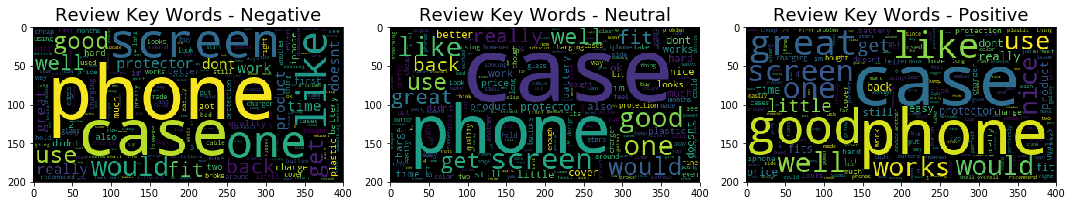

In [26]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(15, 4))
    
axis1.imshow(WordCloud().generate_from_frequencies(neg_reviews_freq_dist))
axis2.imshow(WordCloud().generate_from_frequencies(neu_reviews_freq_dist))
axis3.imshow(WordCloud().generate_from_frequencies(pos_reviews_freq_dist))

axis1.set_title('Review Key Words - Negative', fontsize =18)
axis2.set_title('Review Key Words - Neutral', fontsize =18)
axis3.set_title('Review Key Words - Positive', fontsize =18)


plt.tight_layout()

#### 4.2 Key Words for Summaries
Word clouds for the summaries after cleaning shows more interesting results.  Right away we see that the number two, three, and four stars are one of the most common words in negative, neutral, and positive summaries.  This makes sense considering these numbers correlate to the number of stars used for each sentiment.  

In [27]:
neg_summary_freq_dist = get_word_freq(' '.join(df[df['overall']=='negative']['summary'].apply(clean_text).apply(lambda x: ' '.join(x)).values))
neu_summary_freq_dist = get_word_freq(' '.join(df[df['overall']=='neutral']['summary'].apply(clean_text).apply(lambda x: ' '.join(x)).values))
pos_summary_freq_dist = get_word_freq(' '.join(df[df['overall']=='positive']['summary'].apply(clean_text).apply(lambda x: ' '.join(x)).values))

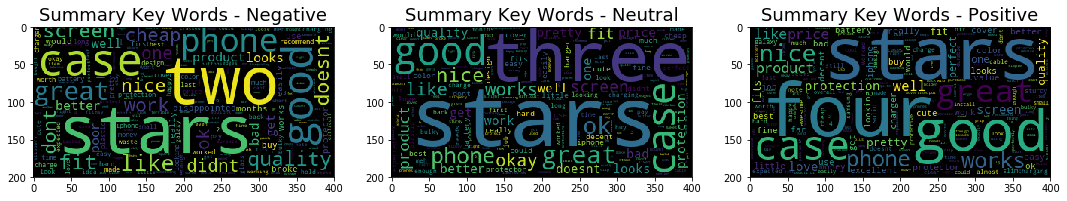

In [28]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(15, 4))
    
axis1.imshow(WordCloud().generate_from_frequencies(neg_summary_freq_dist))
axis2.imshow(WordCloud().generate_from_frequencies(neu_summary_freq_dist))
axis3.imshow(WordCloud().generate_from_frequencies(pos_summary_freq_dist))

axis1.set_title('Summary Key Words - Negative', fontsize =18)
axis2.set_title('Summary Key Words - Neutral', fontsize =18)
axis3.set_title('Summary Key Words - Positive', fontsize =18)

plt.tight_layout()

### 5 - First Models


#### 5.1 - Bag of Words
For the first model, I will use bag of words.  This model essentially gathers all the unique words in all the reviews and then tallies up how many words show up in each review.  The theory is that reviews that have a lot in common, such as all positive reviews, with each other will also have a lot of words in common with each other.  

As always, before training we must split the data into training and test sets.  I'll use a 80:20 split, making sure to stratify the data.  In addition, I'll remove any words that occurs less than 20 times.  

A table of all the results in this section is below:

| Model | Training Accuracy | Test Accuracy | Test Precision | Test Recall |Test f1-Score |
|------|------|------|------|------|------|
|   BOW  | 62.6%| 61.0%| .54| .52|  .53|
|   tf-idf  | 59.7%|  58.5%|  .57|  .43|.41|
|   BOW - Summary | 70.3%|  69.6%| .67|  .62|  .63|
|   tf-idf - Summary | 70.5%|  69.9%| .70|  .60|  .63|
|   BOW - Combined  | 61.5%| 61.1%| .61|.65|.59|
|   tf-idf - Combined | 69.4%| 68.4%|  .71|  .56|  .58|


In [29]:
X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], 
                                                    df['overall'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify = df['overall'])

In [30]:
bow_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer = clean_text, min_df = 20)),
    ('nb_classifier', MultinomialNB())
])

In [31]:
bow_pipeline.fit(X_train, y_train);

In [32]:
nb_pred_bow = bow_pipeline.predict(X_test)

In [33]:
def get_score(x_train, x_test, Y_train, Y_test, pipeline):
    train_prediction = pipeline.predict(x_train)
    test_prediction = pipeline.predict(x_test)
    print('Training Accuracy: {0:.1f}%'.format(accuracy_score(Y_train, train_prediction)*100))
    print('Test Accuracy: {0:.1f}%'.format(accuracy_score(Y_test, test_prediction)*100))
    print('\n')
    print('Test Classification Report')
    print(classification_report(Y_test, test_prediction))

For metrics, I will look at the accuracy as well as precision, recall, and f1 scores.  Here, the training accuracy is ~63% while the test accuracy is ~61%.    The classification report shows that it is mostly the positive reviews are classified correctly while the negative and neutral reviews don't do so well.  |

In [34]:
get_score(X_train, X_test, y_train, y_test, bow_pipeline)

Training Accuracy: 62.6%
Test Accuracy: 61.0%


Test Classification Report
              precision    recall  f1-score   support

    negative       0.48      0.39      0.43     10104
     neutral       0.47      0.34      0.39     17286
    positive       0.68      0.83      0.75     30933

    accuracy                           0.61     58323
   macro avg       0.54      0.52      0.53     58323
weighted avg       0.59      0.61      0.59     58323



#### 5.2 - TF-IDF
Another way to tally up unique words is through a method called tf-idf (term frequency - inverse document frequency).  
This method extends the bag of word model by first tallying up the words as they appear in each review (term frequency).  Then it looks at how many reviews this word appears in.  If the word appears in most/all the reviews, then they can be viewed as unimportant words, and the second part of the method, the inverse document frequency, reduces the importance of this word.  From the wordclouds, some good examples of terms that appear in many reviews are 'phone', 'case', or 'screen'.

In [35]:
tf_idf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer = clean_text, min_df = 20)),
    ('nb_classifier', MultinomialNB())
])

In [36]:
tf_idf_pipeline.fit(X_train, y_train);

The tf-idf model gets a slightly lower accuracy than the bag of words model, with a training accuracy of ~60% and test accuracy of ~58.5%.  In comparison to the bag of word model, the lowered accuracy might be due to the lower recall of the negative and neutral reviews.  

In [37]:
get_score(X_train, X_test, y_train, y_test, tf_idf_pipeline)

Training Accuracy: 59.7%
Test Accuracy: 58.5%


Test Classification Report
              precision    recall  f1-score   support

    negative       0.64      0.14      0.23     10104
     neutral       0.46      0.20      0.28     17286
    positive       0.60      0.95      0.74     30933

    accuracy                           0.59     58323
   macro avg       0.57      0.43      0.41     58323
weighted avg       0.57      0.59      0.51     58323



#### 5.3 - What About the Summary?
As mentioned above, I thought it was possible to use the summary text to get decent results.  Here, I use a similar strategy of splitting up the data into training and tests sets with a 80:20 split and stratify the training set.  

The bag of words and tf-idf methods get similar metric scores, with training and test accuracies at ~70%, which is the highest accuracy yet.  Recall and precision also look much better compared to the reviews.

In [38]:
X_train_summary, X_test_summary, y_train_summary, y_test_summary = train_test_split(df['summary'], 
                                                    df['overall'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify = df['overall'])

In [39]:
bow_pipeline.fit(X_train_summary, y_train_summary);

In [40]:
get_score(X_train_summary, X_test_summary, y_train_summary, y_test_summary, bow_pipeline)

Training Accuracy: 70.3%
Test Accuracy: 69.6%


Test Classification Report
              precision    recall  f1-score   support

    negative       0.60      0.49      0.54     10104
     neutral       0.66      0.48      0.56     17286
    positive       0.73      0.88      0.80     30933

    accuracy                           0.70     58323
   macro avg       0.67      0.62      0.63     58323
weighted avg       0.69      0.70      0.68     58323



In [41]:
tf_idf_pipeline.fit(X_train_summary, y_train_summary);

In [42]:
get_score(X_train_summary, X_test_summary, y_train_summary, y_test_summary, tf_idf_pipeline)

Training Accuracy: 70.5%
Test Accuracy: 69.9%


Test Classification Report
              precision    recall  f1-score   support

    negative       0.70      0.42      0.53     10104
     neutral       0.68      0.47      0.55     17286
    positive       0.70      0.92      0.80     30933

    accuracy                           0.70     58323
   macro avg       0.70      0.60      0.63     58323
weighted avg       0.70      0.70      0.68     58323



Although it is exciting that the summary can get such high accuracies, I worry about the low word count and the model picking up 'two', 'three', and 'four' as the main key words, which wouldn't make for a very robust model.  Combining the summary and review into one document however, shows promising results.  For the bag of words model, both training and test accuracies are ~61.5% whereas for tf-idf has higher accuracies, at ~69%.  

Looking at the classification report, I believe that the combined texts is a better model overall, so I will use that in the future sections.

In [43]:
df['combined_text'] = df.apply(lambda x: x['summary'] + ' ' + x['reviewText'],axis = 1)

In [44]:
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(df['combined_text'], 
                                                    df['overall'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify = df['overall'])

In [45]:
bow_pipeline.fit(X_train_summary, y_train_summary);

In [46]:
get_score(X_train_combined, X_test_combined, y_train_combined, y_test_combined, bow_pipeline)

Training Accuracy: 61.5%
Test Accuracy: 61.1%


Test Classification Report
              precision    recall  f1-score   support

    negative       0.39      0.82      0.53     10104
     neutral       0.55      0.53      0.54     17286
    positive       0.90      0.59      0.71     30933

    accuracy                           0.61     58323
   macro avg       0.61      0.65      0.59     58323
weighted avg       0.70      0.61      0.63     58323



In [47]:
tf_idf_pipeline.fit(X_train_combined, y_train_combined);

In [48]:
get_score(X_train_combined, X_test_combined, y_train_combined, y_test_combined, tf_idf_pipeline)

Training Accuracy: 69.4%
Test Accuracy: 68.4%


Test Classification Report
              precision    recall  f1-score   support

    negative       0.76      0.31      0.44     10104
     neutral       0.68      0.42      0.52     17286
    positive       0.68      0.96      0.79     30933

    accuracy                           0.68     58323
   macro avg       0.71      0.56      0.58     58323
weighted avg       0.69      0.68      0.65     58323



### 6- Improving the Model
From the classification report in the last section, the positive reviews consistently did much better than the negative and neutral reviews.  Most likely this is due to the imbalance in classes.  A simple way to correct for this is to over or under sample before training the model.  For this, I will use the imbalanced-learn library.  

A summary of the results are listed in the table below:

| Model | Training Accuracy | Test Accuracy | Test Precision | Test Recall |Test f1-Score |
|------|------|------|------|------|------|
|   BOW - Oversample  | 71.7% | 70.3%|.66|.68|.66|
|   tfidf - Oversample  | 70.2% | 68.0%|.64|.68|.65|
|   BOW - SMOTE  | 72.4% | 71.1%|.66|.68|.67|
|   tfidf - SMOTE  | 71.6% | 69.6%|.65|.68|.66|
|   BOW - Undersample  | 71.1% | 69.8%|.65|.68|.66|
|   tfidf - Undersample  | 69.4% | 67.5%|.64|.67|.64|


#### 6.1 - Oversampling
With oversampling, the two methods I will use are random oversampling and SMOTE.  

##### 6.1.1 - Random Oversampling
Random oversampling means that the model will pick samples in the dataset at random with replacement until the all classes are represented equally.  In this case, precision and recall are about the same for bow and tf-idf, but the test accuracy is about 1.5% better for bag of words, at ~71.5%.  So far, this is the highest test accuracy.

In [49]:
ros_bow_pipeline = make_pipeline(
    CountVectorizer(analyzer = clean_text, min_df = 20),
    RandomOverSampler(random_state = 42),
    MultinomialNB()
)

In [50]:
ros_bow_pipeline.fit(X_train_combined, y_train_combined);

In [51]:
get_score(X_train_combined, X_test_combined, y_train_combined, y_test_combined, ros_bow_pipeline)

Training Accuracy: 71.7%
Test Accuracy: 70.3%


Test Classification Report
              precision    recall  f1-score   support

    negative       0.51      0.70      0.59     10104
     neutral       0.61      0.57      0.59     17286
    positive       0.84      0.78      0.81     30933

    accuracy                           0.70     58323
   macro avg       0.66      0.68      0.66     58323
weighted avg       0.72      0.70      0.71     58323



In [52]:
ros_tfidf_pipeline = make_pipeline(
    TfidfVectorizer(analyzer = clean_text, min_df = 20),
    RandomOverSampler(random_state = 42),
    MultinomialNB()
)

In [53]:
ros_tfidf_pipeline.fit(X_train_combined, y_train_combined);

In [54]:
get_score(X_train_combined, X_test_combined, y_train_combined, y_test_combined, ros_tfidf_pipeline)

Training Accuracy: 70.2%
Test Accuracy: 68.0%


Test Classification Report
              precision    recall  f1-score   support

    negative       0.48      0.74      0.58     10104
     neutral       0.59      0.55      0.57     17286
    positive       0.86      0.73      0.79     30933

    accuracy                           0.68     58323
   macro avg       0.64      0.68      0.65     58323
weighted avg       0.71      0.68      0.69     58323



##### 6.1.2 - SMOTE
SMOTE, which stands for synthetic minority oversampling technique, is another over sampling method.  Unlike the random over sampler in section 6.1.1 which samples data with replacement, SMOTE will generate new data based on the underrepresented classes.  

One of the hyperparameters for the SMOTE method is k neighbors.  For the bag of words and tf-idf methods, I have plotted the accuracies against the the number of k neighbors to find the optimal number of neighbors.  For bag of words, the optimal number of neighbors is 2500, with an accuracy of 71.1% whereas for tf-idf, the optimal number of neighbors is 100, with a slightly lower accuracy of 69.6%.  

In [55]:
smote_bow_scores = []
smote_bow_range = [1, 500, 1000, 1500, 2000, 2500, 3000]
for k in smote_bow_range:
    tmp_pipeline = make_pipeline(
    CountVectorizer(analyzer = clean_text, min_df = 20),
    SMOTE(random_state = 42, k_neighbors = k),
    MultinomialNB()
);
    tmp_pipeline.fit(X_train_combined, y_train_combined);
    tmp_prediction = tmp_pipeline.predict(X_test_combined)
    smote_bow_scores.append(accuracy_score(y_test_combined, tmp_prediction)*100)

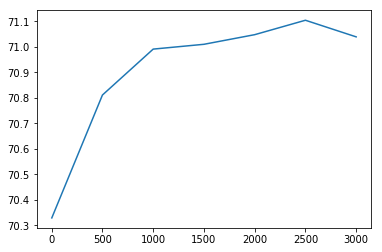

In [56]:
plt.plot(smote_bow_range, smote_bow_scores)

In [57]:
smote_bow_pipeline = make_pipeline(
    CountVectorizer(analyzer = clean_text, min_df = 20),
    SMOTE(random_state = 42, k_neighbors = 2500),
    MultinomialNB()
)

In [58]:
smote_bow_pipeline.fit(X_train_combined, y_train_combined);

In [59]:
get_score(X_train_combined, X_test_combined, y_train_combined, y_test_combined, smote_bow_pipeline)

Training Accuracy: 72.4%
Test Accuracy: 71.1%


Test Classification Report
              precision    recall  f1-score   support

    negative       0.54      0.65      0.59     10104
     neutral       0.62      0.57      0.59     17286
    positive       0.82      0.81      0.82     30933

    accuracy                           0.71     58323
   macro avg       0.66      0.68      0.67     58323
weighted avg       0.72      0.71      0.71     58323



In [60]:
smote_tfidf_scores = []
smote_tfidf_range = [1, 100, 250, 500]
for k in smote_tfidf_range:
    tmp_pipeline = make_pipeline(
    TfidfVectorizer(analyzer = clean_text, min_df = 20),
    SMOTE(random_state = 42, k_neighbors = k),
    MultinomialNB()
);
    tmp_pipeline.fit(X_train_combined, y_train_combined);
    tmp_prediction = tmp_pipeline.predict(X_test_combined)
    smote_tfidf_scores.append(accuracy_score(y_test_combined, tmp_prediction)*100)

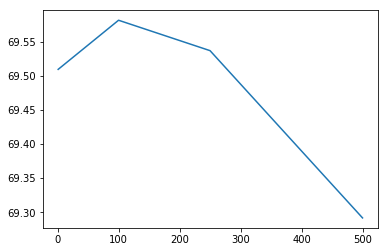

In [61]:
plt.plot(smote_tfidf_range, smote_tfidf_scores)

In [62]:
smote_tfidf_pipeline = make_pipeline(
    TfidfVectorizer(analyzer = clean_text, min_df = 20),
    SMOTE(random_state = 42, k_neighbors = 100),
    MultinomialNB()
);

In [63]:
smote_tfidf_pipeline.fit(X_train_combined, y_train_combined);

In [64]:
get_score(X_train_combined, X_test_combined, y_train_combined, y_test_combined, smote_tfidf_pipeline)

Training Accuracy: 71.6%
Test Accuracy: 69.6%


Test Classification Report
              precision    recall  f1-score   support

    negative       0.50      0.72      0.59     10104
     neutral       0.61      0.54      0.57     17286
    positive       0.84      0.78      0.81     30933

    accuracy                           0.70     58323
   macro avg       0.65      0.68      0.66     58323
weighted avg       0.71      0.70      0.70     58323



#### 6.2 - Undersampling
There are a few under sampling methods in the imbalanced-learn library, but I only show the RandomUnderSampler method because it had the best results of those I tried.  This method is essentially the opposite of the RandomOverSampler method, where data is randomly selected from the target class so that all classes are equal.  

In [65]:
rus_bow_pipeline = make_pipeline(
    CountVectorizer(analyzer = clean_text, min_df = 20),
    RandomUnderSampler(random_state = 42),
    MultinomialNB()
)

In [66]:
rus_bow_pipeline.fit(X_train_combined, y_train_combined);

In [67]:
get_score(X_train_combined, X_test_combined, y_train_combined, y_test_combined, rus_bow_pipeline)

Training Accuracy: 71.1%
Test Accuracy: 69.8%


Test Classification Report
              precision    recall  f1-score   support

    negative       0.50      0.70      0.59     10104
     neutral       0.61      0.56      0.59     17286
    positive       0.85      0.77      0.81     30933

    accuracy                           0.70     58323
   macro avg       0.65      0.68      0.66     58323
weighted avg       0.72      0.70      0.70     58323



In [68]:
rus_tfidf_pipeline = make_pipeline(
    TfidfVectorizer(analyzer = clean_text, min_df = 20),
    RandomUnderSampler(random_state = 42),
    MultinomialNB()
)

In [69]:
rus_tfidf_pipeline.fit(X_train_combined, y_train_combined);

In [70]:
get_score(X_train_combined, X_test_combined, y_train_combined, y_test_combined, rus_tfidf_pipeline)

Training Accuracy: 69.4%
Test Accuracy: 67.5%


Test Classification Report
              precision    recall  f1-score   support

    negative       0.47      0.75      0.58     10104
     neutral       0.59      0.55      0.57     17286
    positive       0.86      0.72      0.79     30933

    accuracy                           0.68     58323
   macro avg       0.64      0.67      0.64     58323
weighted avg       0.71      0.68      0.68     58323



### 7 - Deep Learning Model
Deep learning models have had much success working with text and sentiment analysis.  Popular methods include basic neural networks, convolutional neural networks (CNN) and long short term memory networks (LSTM).  In this project, I keep it simple and only use a basic neural network and word2vec; more in depth models such as CNN and LSTM will be explored in the future.

word2vec is a method to turn text into a set of vectors (word embeddings) that can determine if two words are similar to each other or not.  Without getting into the math, word2vec can calculate if two words are similar to each other (i.e cappuccino and espresso), or the classic example of computing king - man + woman = queen.  You can see that word2vec is able to identify relationships between words much like humans can do.

#### 7.1 - Preprocessing the Text
The first step is to clean the text.  I used the combined text (summary and review joined together) here as it seemed to have the best results in the previous sections. Similar to the models above, I remove punctuation and make everything lowercased.  However, I do NOT remove stop words.  As always, I split the data into a training and test set.  

In [71]:
df_clean = pd.DataFrame()
df_clean['combined_text'] = df['combined_text'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)).lower())
df_clean['overall'] = df['overall']

In [72]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(df_clean['combined_text'],
                                                                    df_clean['overall'], 
                                                                    test_size=0.2, 
                                                                    random_state=42,
                                                                   stratify = df_clean['overall'])

I also need to convert the target labels into numbers.  I decided to convert negative, neutral, and positive to 0, 1, and 2 respectively.

In [73]:
overall_dict = {'negative': 0, 'neutral': 1, 'positive':2}

In [74]:
y_train_w2v = y_train_w2v.apply(lambda x: overall_dict[x])
y_test_w2v = y_test_w2v.apply(lambda x: overall_dict[x])

#### 7.2 - Building the word2vec Model
Before applying the training set into the model, it has to be converted to a TaggedDocument object instead.  The result is that there is a list of tokens with a label.  The label is whether it is from the training or test set and a unique number after that (i.e.  train0, train1, etc.).  An example of the TaggedDocument object is below.

In [75]:
# def tag_reviews(col, label_type):
#     tagged_lst = []
#     for i,sentence in enumerate(col):
#         label = label_type + str(i)
#         tagged_lst.append(TaggedDocument(sentence.split(), [label]))
#     return tagged_lst
def tag_reviews(col, label_type):
    return [TaggedDocument(sentence.split(), [label_type + str(i)]) for i, sentence in enumerate(col)]



X_train_w2v = tag_reviews(X_train_w2v, 'train')
X_test_w2v = tag_reviews(X_test_w2v, 'test')

In [76]:
X_train_w2v[0]

TaggedDocument(words=['nice', 'cover', 'the', 'color', 'purple', 'looks', 'more', 'like', 'dark', 'pink', 'so', 'it', 'looks', 'too', 'similar', 'to', 'the', 'pink', 'one', 'that', 'i', 'already', 'have', 'no', 'statement', 'came', 'with', 'the', 'cover', 'so', 'i', 'couldnt', 'exchange', 'it', 'for', 'a', 'different', 'color', 'otherwise', 'is', 'a', 'good', 'cover', 'and', 'it', 'has', 'a', 'strong', 'grip', 'on', 'the', 'cell', 'phone', 'fits', 'perfectly', 'just', 'dont', 'order', 'both', 'pink', 'and', 'purple', 'color', 'they', 'are', 'almost', 'the', 'same'], tags=['train0'])

Next, I need to initialize the word2vec model.  I've set the vector size to 300 and filtered out words that appeared less than 20 times.  Next is to build the vocabulary, and lastly is to train the model.  

In [77]:
n_dim = 300

In [78]:
combined_w2v = Word2Vec(size = n_dim, min_count = 20)
combined_w2v.build_vocab([x.words for x in X_train_w2v])

for epoch in range(10):
    combined_w2v.train([x.words for x in X_train_w2v], total_examples= combined_w2v.corpus_count, epochs = epoch)

A cool feature of word2vec is that you can find words in the corpus that are similar to your target word.  As a sanity check, lets see if the results for 'phone' and 'great' make sense.  

For phone, the most similar words are device, cellphone, and tablet.  For great, the most similar words are good, fantastic, and awesome.  Seems like the word2vec model works!

In [79]:
combined_w2v.most_similar('phone')

/home/crystal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('device', 0.5878384113311768),
 ('cellphone', 0.5106213688850403),
 ('tablet', 0.48109865188598633),
 ('watch', 0.4332633912563324),
 ('iphone', 0.42486572265625),
 ('it', 0.39989173412323),
 ('hand', 0.394573450088501),
 ('phoneit', 0.3817780613899231),
 ('gs4', 0.381282240152359),
 ('case', 0.37848636507987976)]

In [80]:
combined_w2v.most_similar('great')

/home/crystal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('good', 0.8273035287857056),
 ('fantastic', 0.7329045534133911),
 ('awesome', 0.7263761758804321),
 ('nice', 0.7017671465873718),
 ('amazing', 0.6623478531837463),
 ('wonderful', 0.6565007567405701),
 ('decent', 0.6423090100288391),
 ('excellent', 0.6410274505615234),
 ('perfect', 0.5995833873748779),
 ('fine', 0.5968351364135742)]

#### 7.3 - Building the Sentiment Classifier
Lastly, to classify the reviews, we need to convert the word2vec model into vectors as well.  [Ahmed Besbes's idea](https://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html) to do this was to compute a weighted average where the weight correlates to the importance of the word.  Sounds familiar?  It should, as that's similar to what tf-idf does.  The following code is how Ahmed builds a tf-idf matrix and converts them to vectors.  

In [81]:
w2v_vectorizer = TfidfVectorizer(analyzer = lambda x: x, min_df = 5)
w2v_matrix = w2v_vectorizer.fit_transform([x.words for x in X_train_w2v])
w2v_tfidf = dict(zip(w2v_vectorizer.get_feature_names(), w2v_vectorizer.idf_))

In [82]:
def WordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += w2v[word].reshape(1, size) * w2v_tfidf[word]
            count += 1
        except:
            continue
    if count != 0:
        vec /= count
    return vec

Lastly, the vectors should be scaled.

In [83]:
train_vecs_w2v = np.concatenate([WordVector(z, n_dim) for z in map(lambda x: x.words, X_train_w2v)])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([WordVector(z, n_dim) for z in map(lambda x: x.words, X_test_w2v)])
test_vecs_w2v = scale(test_vecs_w2v)

The vectors are finally ready to be fed into a neural network!  I use Keras because it is easy to build layers and add activation functions. The following neural network is a basic two layer architecture.  Unfortunately, the accuracy is extremely low, at ~30% for the test set.  

In [84]:
basic_2layer_model = Sequential()
basic_2layer_model.add(Dense(64, activation = 'relu', input_dim = n_dim))
basic_2layer_model.add(Dense(1, activation = 'sigmoid'))
basic_2layer_model.compile(optimizer='rmsprop',
                          loss = 'binary_crossentropy',
                          metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [85]:
basic_2layer_model.fit(train_vecs_w2v, y_train_w2v, epochs = 10, batch_size= 256, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
233289/233289 [==============================] - 3s 14us/step - loss: 0.3319 - accuracy: 0.2963
Epoch 2/10
233289/233289 [==============================] - 3s 13us/step - loss: -0.2570 - accuracy: 0.2964
Epoch 3/10
233289/233289 [==============================] - 3s 13us/step - loss: -0.7112 - accuracy: 0.2964
Epoch 4/10
233289/233289 [==============================] - 3s 13us/step - loss: -1.0931 - accuracy: 0.2964
Epoch 5/10
233289/233289 [==============================] - 3s 13us/step - loss: -1.4412 - accuracy: 0.2964
Epoch 6/10
233289/233289 [==============================] - 3s 13us/step - loss: -1.7743 - accuracy: 0.2964
Epoch 7/10
233289/233289 [==============================] - 3s 13us/step - loss: -2.1016 - accuracy: 0.2964
Epoch 8/10
233289/233289 [==============================] - 3s 13us/step - loss: -2.4257 - accuracy: 0.2964
Epoch 9/10
233289/233289 [==============================] - 3s 13us/step - loss: -2.7496 

In [86]:
basic_2layer_model.evaluate(test_vecs_w2v, y_test_w2v, batch_size=256, verbose = 1)

58323/58323 [==============================] - 0s 6us/step


[-3.2339746473527335, 0.29638391733169556]

### 8 - Conclusion and Future Research
In this project, I've applied sentiment analysis on amazon reviews and summary specifically for cell phone and accessories products.  In the first part of the project, I applied bag of words and tf-idf models to achieve accuracy highs of 68.4% for reviews and 69.6% for summaries.  Attempts to improve the model included over and undersampling, with the highest test accuracy at 71.1% through SMOTE and bag of words.  I also applied a neural network with a word2vec model, but that had a disappointing 30% accuracy.  

There are plenty of ideas to continue improving upon this project.  Some natural next steps would be to fix common spelling errors, apply n-grams (phrases), and apply stemming and lemmatization.  On the neural network side, I can try CNN and LSTM instead of a basic 2 layer model, and instead of training my own word2vec model, I can use a pre-trained one such as GoogleNews.  

Further down the road, I'd like to re-introduce the 1 and 5 star reviews after removing fake reviews (which is a whole other project in itself).  It would also be useful to break down sentiment based on categories such as quality, price point, and customer service.  